In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.rcParams['figure.figsize']=(10,8)

### ELS의 등장? 굳이 차트 봐가면서 파생 할 필요 없음!

### ELB 형태로는

* DIGITAL CALL
* UP AND OUT CALL
* UP AND OUT CALL & DOWN AND OUT PUT 이 대표적이다.

### 이중에 우리는 DIGITAL CALL을 평가할 계획.

### ELS 발행정보를 보고 싶다면

http://dart.fss.or.kr/dsab002/main.do# 에서 보고서명에 '일괄신고추가서류(파생결합증권-주가연계증권)'을 넣고 검색하면 쫘르륵 뜬다.

(Dart 홈페이지 => 공시서류검색 => 상세검색 => 보고서명 넣기)

cf) ELB는 '일괄신고추가서류(파생결합사채-주가연계파생결합사채)'라 검색하면 된다.

## Numerical

In [303]:
#Digital call pricing
#만약 만기때의 주가가 시작가보다 100% 이상이면 연 수익률 1.2%를 주고
#이하면 연 수익률 1.1%를 준다.
#원금 100만원을 넣었다면 현재시점에선 얼마의 수익을 얻을수 있을까?


n=252
times=np.linspace(0,1,n+1)
dtimes=np.diff(times)

mcnum=500

s=np.zeros((mcnum,len(times)))
s0=300
s[:,0]=np.log(s0) # 주가의 시작

mu=0.12 #주가의 수익률
sigma=0.2 #주가의 변동성



for i,dt in enumerate(dtimes):
    w=np.random.normal(size=mcnum)
    dw=np.sqrt(dt)*w
    s[:,i+1]=s[:,i]+(mu-0.5*sigma**2)*dt+sigma*dw

s=np.exp(s) #최종 주가 path

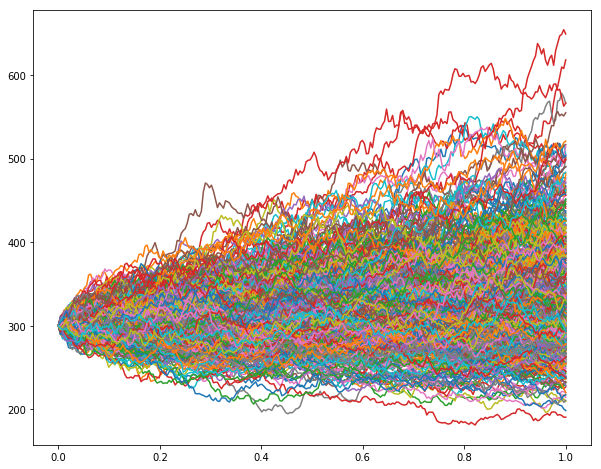

In [304]:
for a in range(mcnum):
    plt.plot(times,s[a,:])

In [305]:
max(s[:,-1])

649.2359096210932

In [261]:
s_last=s[:,-1]

pp=np.zeros_like(s_last)

zrate=0.02 #무위험 수익률, 즉 국채
T=1
discount=np.exp(zrate*T) #할인율

up=0.012
down=0.011
Principle=1000000 #원금

for i,ss in enumerate(s_last): # 기준에 맞으면 1+UP을 주고, 안맞으면 1+DOWN을 준다.
    if ss/s0>=1: #ss/s0 : 기준가격 
        pp[i]=1+up
    else:
        pp[i]=1+down
        
ppe=Principle*pp
value=discount*np.mean(ppe)

print('Numerical 현재가격은 {:.2f}'.format(value),'원')

Numerical 현재가격은 1032135.66 원


In [198]:
len(pp[pp==1+up]),len(pp[pp==1+down]) #조건을 넘거나 못넘은 갯수

(345, 155)

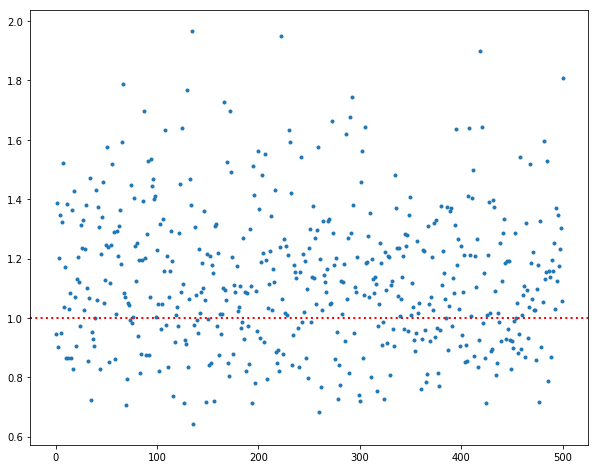

In [199]:
#만기 조건의 내용 시각화
plt.scatter(np.linspace(0,mcnum,mcnum),s[:,-1]/s[:,0],s=9)
plt.axhline(y=1,color='red',linewidth=2,linestyle=':')

## Analytic

In [174]:
#Digital call pricing
#만약 만기때의 주가가 시작가보다 100% 이상이면 연 수익률 1.2%를 주고
#이하면 연 수익률 1.1%를 준다.
#원금 100만원을 넣었다면 현재시점에선 얼마의 수익을 얻을수 있을까?


In [200]:
def blackscholes(s,k,r,T,sigma):
    
    d1=(np.log(s/k)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    
    call = s*norm.cdf(d1)-k*np.exp(-r*T)*norm.cdf(d2)
    return call

Text(0, 0.5, '$Option price$')

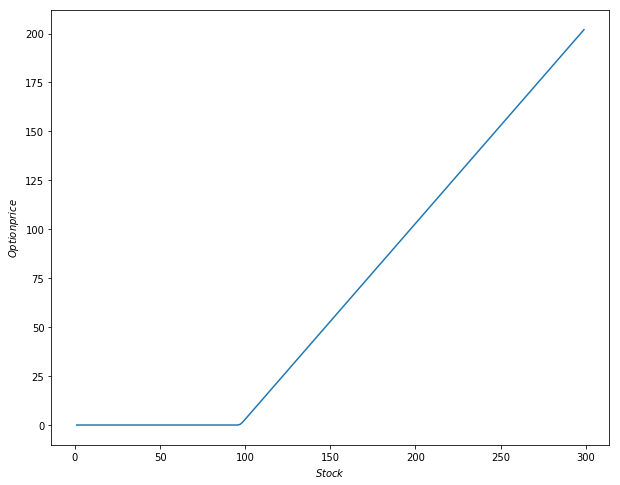

In [136]:
s=np.arange(1,300,1) #주가
k=100 #행사가격
r=0.03 #무위험이자율
T=1 #시간
sigma=0.01 #변동성


plt.plot(s,blackscholes(s,k,r,T,sigma),label='sigma={:.2f}'.format(sigma))
plt.xlabel('$Stock$')
plt.ylabel('$Option price$')

In [316]:
def digital(s,k,r,T,sigma): #Black scholes call option price를 활용
    
    d1=(np.log(s/k)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    
    digital_call=norm.cdf(d2)
    return digital_call

Text(0, 0.5, '$Option price$')

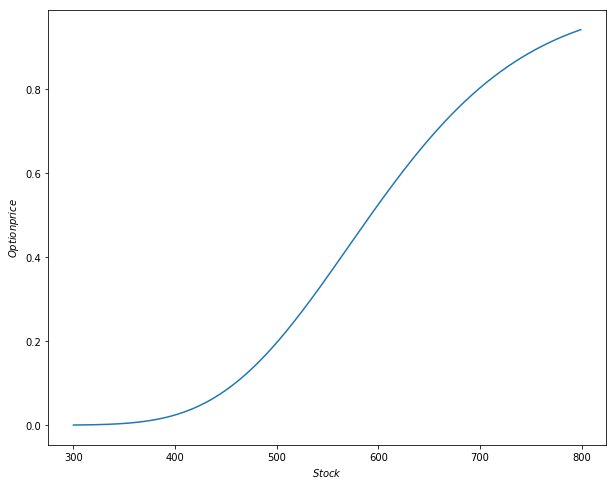

In [317]:
s=np.arange(300,800,1) #주가
k=s[0]*2 #행사가격
r=0.03 #무위험이자율
T=1 #시간
sigma=0.2 #변동성
a=1000000
up=1.012

price_up=up*digital(s,k,r,T,sigma)

plt.plot(s,price_up,label='sigma={:.2f}'.format(sigma))
plt.xlabel('$Stock$')
plt.ylabel('$Option price$')

In [318]:
len(s)

500

In [319]:
pp=np.zeros_like(s)
for i in range(len(s)):
    if s[i]>=k:
        pp[i]=min(a*(1+price_up[i]),a*1.012) #기초자산의 가격이 올라도 어차피 내가 줄 돈은 1.2%로 고정되어있음.
    else:
        pp[i]=a*1.011

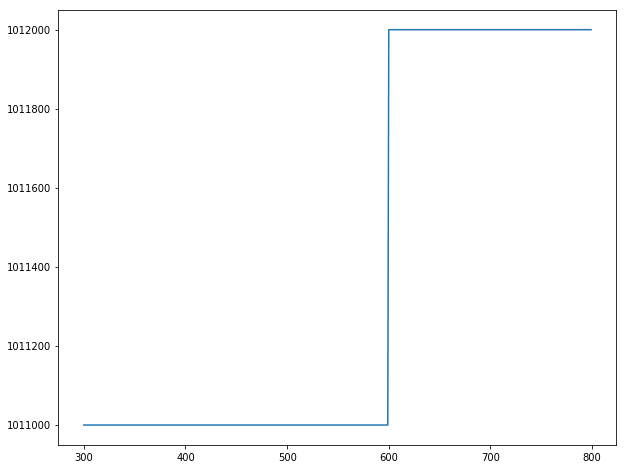

In [320]:
plt.plot(s,pp) #만기 시점 가격 구조 

In [321]:
V=np.mean(pp)*discount
print('Analytic 현재가격은 {:.2f}'.format(V),'원')

Analytic 현재가격은 1031831.02 원


### 결론: Numerical과 Analytic의 차이가 그리 많이 안난다.